In [1]:
import sys
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random
import time

from scipy.stats import poisson
from scipy.stats import norm
from scipy.integrate import simps

from os import listdir
import re

matplotlib.rcParams.update({'font.size': 14})

In [2]:
expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')

expEnergy = expectedData1[:,0]
# expFlu has units of GeV^-1 cm^-2 s^-1
# Multiply by energy bin width (200 GeV/bin) to change to cm^-2 s^-1 /bin

expFluNmu = expectedData1[:,1] * 200
expFluPmu = expectedData2[:,1] * 200

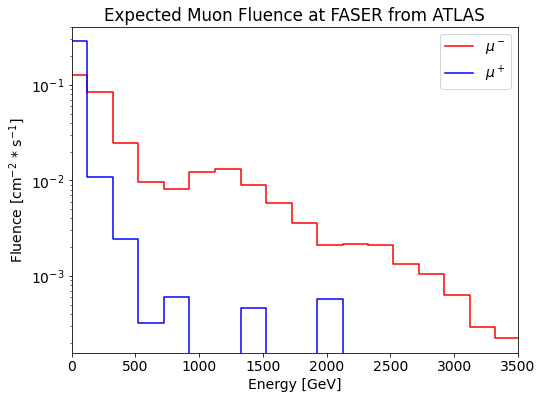

In [3]:
fig = plt.figure(figsize=(8,6))

posY = expFluPmu
negY = expFluNmu

plt.step(np.append(0,expEnergy), np.append(negY[0],negY), linestyle='-', color='r', label='$\mu^-$')
plt.step(np.append(0,expEnergy), np.append(posY[0],posY), linestyle='-', color='b', label='$\mu^+$')

plt.xlim([0,3500])

plt.yscale('log')
plt.legend()

plt.xlabel('Energy [GeV]')
plt.ylabel('Fluence [cm$^{-2}$ * s$^{-1}$]')
plt.title('Expected Muon Fluence at FASER from ATLAS')

fig.savefig('GeneratedPlots/expMuonFluence.pdf')

In [4]:
LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC

A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2
A_c = 35 * 30 # center cimulation area in cm^2
A_tot = A_lr + A_tb + A_c
veto = 10 ** -6
A_tot_veto = A_lr + A_tb + A_c * veto

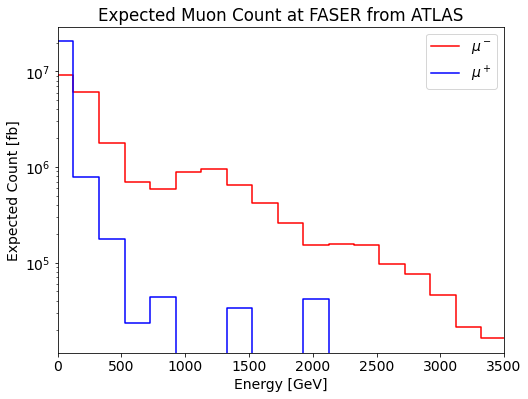

In [5]:
fig = plt.figure(figsize=(8,6))

posY = expFluPmu * A_tot / LHCflu
negY = expFluNmu * A_tot / LHCflu

plt.step(np.append(0,expEnergy), np.append(negY[0],negY), linestyle='-', color='r', label='$\mu^-$')
plt.step(np.append(0,expEnergy), np.append(posY[0],posY), linestyle='-', color='b', label='$\mu^+$')

plt.xlim([0,3500])

plt.yscale('log')
plt.legend()

plt.xlabel('Energy [GeV]')
plt.ylabel('Expected Count [fb]')
plt.title('Expected Muon Count at FASER from ATLAS')

fig.savefig('GeneratedPlots/expMuonCount.pdf')

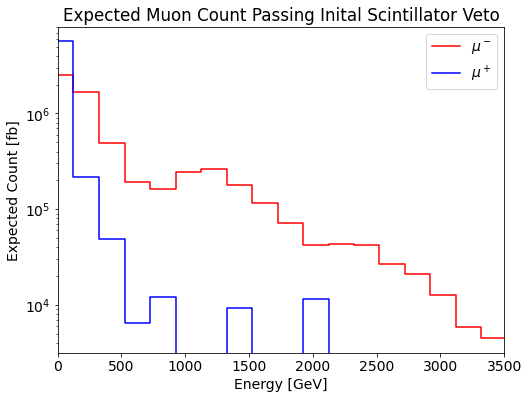

In [6]:
fig = plt.figure(figsize=(8,6))

posY = expFluPmu * A_tot_veto / LHCflu
negY = expFluNmu * A_tot_veto / LHCflu

plt.step(np.append(0,expEnergy), np.append(negY[0],negY), linestyle='-', color='r', label='$\mu^-$')
plt.step(np.append(0,expEnergy), np.append(posY[0],posY), linestyle='-', color='b', label='$\mu^+$')

plt.xlim([0,3500])

plt.yscale('log')
plt.legend()

plt.xlabel('Energy [GeV]')
plt.ylabel('Expected Count [fb]')
plt.title('Expected Muon Count Passing Inital Scintillator Veto')

fig.savefig('GeneratedPlots/expMuonCountPass.pdf')

# Plots for expected and simulated counts

## Muons

In [7]:
def countSimTotals(files):

    simTot = {}
    for side in ['left', 'right', 'top', 'bot']:
        sideDict = {}
        sideFiles = [file for file in files if re.search(f'.*{side}.*', file)]
        for file in sideFiles:
            energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
            if not(energy in sideDict.keys()):
                sideDict[energy] = 21527
            else:
                sideDict[energy] += 21527
        simTot[side] = sideDict
    # Determine simTot for center
    centerDict = {}
    centerFile = [file for file in files if re.search(f'.*center.*', file)]
    for file in centerFile:
        energy = np.load('NumpyArrays/' + file, allow_pickle=True)[0]['primaryEnergy']
        if not(energy in centerDict.keys()):
            centerDict[energy] = 20000
        else:
            centerDict[energy] += 20000
    simTot['center'] = centerDict

    return simTot



In [8]:
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muons',file)]
    

data = np.array([])
        
# Load fluence files for muons and anti-muons and combine them
expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')

expEnergy = expectedData1[:,0]
expFlu    = expectedData1[:,1] + expectedData2[:,1]

# expFlu has units of GeV^-1 cm^-2 s^-1
# Multiply by energy bin width (200 GeV/bin) to change to cm^-2 s^-1 /bin
expFlu = expFlu * 200

LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC
expFlu = expFlu / LHCflu # fb (at the LHC) * cm^-2 (per unit area at FASER) per bin

A_lr = 6.5 * 35 # left/right simulation area in cm^2
A_tb = 43  * 4 # top/bot simulation area in cm^2
A_c = 35 * 30 # center cimulation area in cm^2

expTot_lr = expFlu * A_lr
expTot_tb = expFlu * A_tb
expTot_c = expFlu * A_c * veto

expTot = 2 * (expTot_lr + expTot_tb) + expTot_c

# Number simulated in each region for each input file
simTotDict = countSimTotals(files)

In [9]:
energies = np.sort(np.fromiter(simTotDict['left'].keys(), dtype=float))

simTot = []
for energy in energies:
    totals = [simTotDict[side][energy] for side in ['left', 'right', 'top', 'bot', 'center']]
    simTot.append(np.sum(totals))

simTot = np.array(simTot)

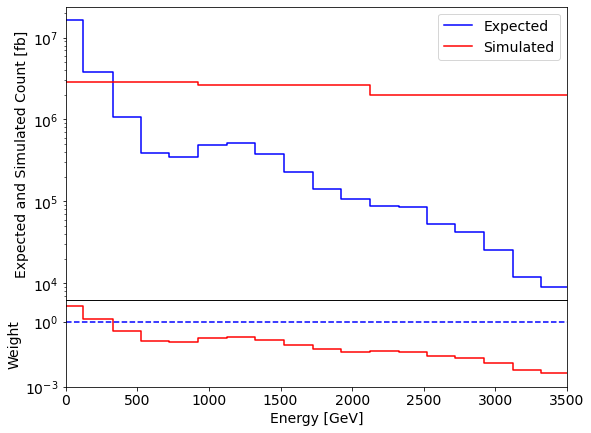

In [19]:
lum = 1
weights = (expTot*lum)/simTot

fig = plt.figure(figsize=(8,6))
# Setup some nice axes
x0, x1 = 0.11, 0.98
y0, y1 = 0.1, 0.88 # 0.20 = 0.05 + 0.9/6
h = 0.2

ax0 = fig.add_axes([x0 , y0    , (x1-x0), h])
ax1 = fig.add_axes([x0 , y0 + h, (x1-x0), y1-h])

# Plot the weights
ax0.step(np.append(0,expEnergy), np.append(weights[0],weights), linestyle='-', color='r')
ax0.step(np.append(0,3500), np.append(1,1), linestyle='--', color='b')

ax0.set_xlim([0,3500])
ax0.set_ylim([10**-3,10])
ax0.set_yscale('log')
ax0.set_yticks([10**-3,1])

ax0.set_xlabel('Energy [GeV]')
ax0.set_ylabel('Weight')


# Plot the counts
ax1.step(np.append(0,expEnergy), np.append(expTot[0]*lum,expTot*lum), linestyle='-', color='b', label='Expected')
ax1.step(np.append(0,expEnergy), np.append(simTot[0],simTot), linestyle='-', color='r', label='Simulated')

ax1.set_xlim([0,3500])
ax1.set_yscale('log')
ax1.legend()
ax1.set_xticks([])
# ax1.set_xlabel('Energy [GeV]')
ax1.set_ylabel('Expected and Simulated Count [fb]')

fig.savefig('GeneratedPlots/Fig_exp_sim_mu.pdf')

## Neutrinos

In [11]:
# Setup variables for weighting neutrino events.
volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
rhoTung = 19.3           # Density of tungsten
volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
rhoLead = 11.35          # Density of lead
volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation

# Weight by the masses of the targets
tungWeight = (volTung/volFlu)
leadWeight = volLead/volFlu * rhoLead/rhoTung

# Import data for the number of expected muon neutrino interactions during run 3
expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')

expEnergy_numu = expectedData1[:,0]
expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1

expTot_numu = (tungWeight + leadWeight) * expTotal

# Import data for the number of expected muon neutrino interactions during run 3
expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')

expEnergy_numu = expectedData1[:,0]
expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1

expTot_numu = (tungWeight + leadWeight) * expTotal

# Import data for the number of expected muon neutrino interactions during run 3
expectedData1 = np.loadtxt('FluenceFiles/FASER_-12.txt')
expectedData2 = np.loadtxt('FluenceFiles/FASER_12.txt')

expEnergy_nuel = expectedData1[:,0]
expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1

expTot_nuel = (tungWeight + leadWeight) * expTotal

# simTotals
n_layers = 13 + 5 # 13 in Tungsten, 5 in Lead
sim_layer_numu = 1000
sim_layer_nuel = 300

simTot_numu = n_layers * sim_layer_numu
simTot_nuel = n_layers * sim_layer_nuel

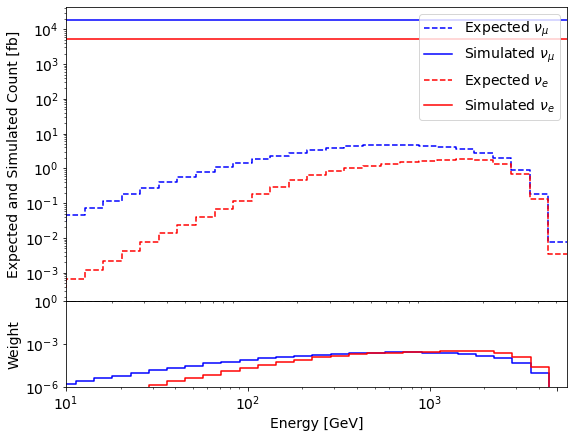

In [18]:
lum = 1
weights_numu = (expTot_numu*lum)/simTot_numu
weights_nuel = (expTot_nuel*lum)/simTot_nuel

fig = plt.figure(figsize=(8,6))
# Setup some nice axes
x0, x1 = 0.11, 0.98
y0, y1 = 0.1, 0.88 # 0.20 = 0.05 + 0.9/6
h = 0.2

ax0 = fig.add_axes([x0 , y0    , (x1-x0), h])
ax1 = fig.add_axes([x0 , y0 + h, (x1-x0), y1-h])

# Plot the weights
ax0.step(np.append(0,expEnergy_numu), np.append(weights_numu[0],weights_numu), linestyle='-', color='b')
ax0.step(np.append(0,expEnergy_nuel), np.append(weights_nuel[0],weights_nuel), linestyle='-', color='r')
ax0.step(np.append(0,np.max(expEnergy_numu)), np.append(1,1), linestyle='--', color='k')

ax0.set_xlim([np.min(expEnergy_numu),np.max(expEnergy_numu)])
ax0.set_ylim([10**-6,1])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xticks([10, 100, 1000, 5000])
ax0.set_yticks([10**-6,10**-3,1])

ax0.set_xlabel('Energy [GeV]')
ax0.set_ylabel('Weight')


# Plot the counts
ax1.step(np.append(0,expEnergy_numu), np.append(expTot_numu[0]*lum,expTot_numu*lum),
         linestyle='--', color='b', label='Expected $\\nu_\mu$')
ax1.plot([0,np.max(expEnergy_numu)], [simTot_numu,simTot_numu],
         linestyle='-', color='b', label='Simulated $\\nu_\mu$')
ax1.step(np.append(0,expEnergy_nuel), np.append(expTot_nuel[0]*lum,expTot_nuel*lum),
         linestyle='--', color='r', label='Expected $\\nu_e$')
ax1.plot([0,np.max(expEnergy_nuel)], [simTot_nuel,simTot_nuel],
         linestyle='-', color='r', label='Simulated $\\nu_e$')

ax1.set_xlim([np.min(expEnergy_numu),np.max(expEnergy_numu)])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.set_xticks([])
# ax1.set_xlabel('Energy [GeV]')
ax1.set_ylabel('Expected and Simulated Count [fb]')

fig.savefig('GeneratedPlots/Fig_exp_sim_nu.pdf')